In [1]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os


from dgl.dataloading import MultiLayerFullNeighborSampler, DataLoader

from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNetSample import MeshGraphNet

In [2]:
class MGNTrainer:
    def __init__(self, cfg: DictConfig, rank_zero_logger: RankZeroLoggingWrapper):
        assert DistributedManager.is_initialized()
        self.dist = DistributedManager()

        self.amp = cfg.amp

        # instantiate dataset
        self.dataset = TelemacDataset(
            name="telemac_train",
            data_dir=to_absolute_path(cfg.data_dir),
            dynamic_data_file= to_absolute_path(cfg.dynamic_dir),
            split="train",
            num_samples=cfg.num_training_samples,
            num_steps=cfg.num_training_time_steps
        )


        # instantiate the model
        self.model = MeshGraphNet(
            cfg.num_input_features,
            cfg.num_edge_features,
            cfg.num_output_features,
            processor_size=3,
            hidden_dim_processor=128,
            hidden_dim_node_encoder=128,
            hidden_dim_edge_encoder=128,
            hidden_dim_node_decoder=128,
            do_concat_trick=cfg.do_concat_trick,
            num_processor_checkpoint_segments=cfg.num_processor_checkpoint_segments,
        )
        
        if cfg.jit:
            if not self.model.meta.jit:
                raise ValueError("MeshGraphNet is not yet JIT-compatible.")
            self.model = torch.jit.script(self.model).to(self.dist.device)
        else:
            self.model = self.model.to(self.dist.device)


        # distributed data parallel for multi-node training
        if self.dist.world_size > 1:
            self.model = DistributedDataParallel(
                    self.model,
                    device_ids=[self.dist.local_rank],
                    output_device=self.dist.device,
                    broadcast_buffers=self.dist.broadcast_buffers,
                    find_unused_parameters=self.dist.find_unused_parameters,
                )

        # enable train mode
        self.model.train()

        # instantiate loss, optimizer, and scheduler
        self.criterion = torch.nn.MSELoss()

        self.optimizer = None
        try:
            if cfg.use_apex:
                from apex.optimizers import FusedAdam

                self.optimizer = FusedAdam(self.model.parameters(), lr=cfg.lr)
        except ImportError:
            rank_zero_logger.warning(
                    "NVIDIA Apex (https://github.com/nvidia/apex) is not installed, "
                    "FusedAdam optimizer will not be used."
            )
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=cfg.lr)
        rank_zero_logger.info(f"Using {self.optimizer.__class__.__name__} optimizer")

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer, lr_lambda=lambda epoch: cfg.lr_decay_rate**epoch
            )
        self.scaler = GradScaler()

        # load checkpoint
        if self.dist.world_size > 1:
            torch.distributed.barrier()

        #self.epoch_init = load_checkpoint(
        #        to_absolute_path(cfg.ckpt_path),
        #        models=self.model,
        #        optimizer=self.optimizer,
        #        scheduler=self.scheduler,
        #        scaler=self.scaler,
        #        device=self.dist.device,
        #    )

    def train(self, input_nodes, seeds, blocks,common_edges):
        self.model.train()
        self.optimizer.zero_grad()
        loss = self.forward(input_nodes, seeds, blocks,common_edges)
        self.backward(loss)
        self.scheduler.step()
        return loss

    def forward(self, input_nodes, seeds, blocks,common_edges):
        with autocast(enabled=self.amp):
            node_features=  blocks[0].srcdata['x'].to(self.dist.device)
            edge_features = blocks[0].edata['x'].to(self.dist.device)
            common_edges = [c.to(self.dist.device) for c in common_edges]
            blocks = [b.to(self.dist.device) for b in blocks]
            pred = self.model(node_features,edge_features,blocks,common_edges)
            loss = self.criterion(pred, blocks[-1].dstdata['y'].to(self.dist.device))
            return loss
        
    def backward(self, loss):
        # backward pass
        if self.amp:
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
        else:
            loss.backward()
            self.optimizer.step()

In [3]:
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf

# Initialize Hydra and set the configuration directory
with initialize(config_path="../bin/conf"):
    # Compose the configuration using the config n
    cfg = compose(config_name="config_Tet_sample")
    # initialize distributed manager
    DistributedManager.initialize()
    dist = DistributedManager()

    logger = PythonLogger("main")  # General python logger
    rank_zero_logger = RankZeroLoggingWrapper(logger, dist)  # Rank 0 logger
    rank_zero_logger.file_logging()

    trainer = MGNTrainer(cfg, rank_zero_logger)
    
    
    



/tmp/ipykernel_795/1293655035.py:6: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../bin/conf"):


{'h': tensor([0.0501]), 'u': tensor([-0.0049]), 'v': tensor([-0.0021]), 'strickler': tensor([20.6628]), 'z': tensor([17.5927]), 'delta_h': tensor([0.0041]), 'delta_u': tensor([0.0004]), 'delta_v': tensor([-0.0013]), 'h_std': tensor([0.2690]), 'u_std': tensor([0.1437]), 'v_std': tensor([0.0908]), 'strickler_std': tensor([11.6977]), 'z_std': tensor([13.9988]), 'delta_h_std': tensor([0.0982]), 'delta_u_std': tensor([0.1453]), 'delta_v_std': tensor([0.0866])}
{'xrel': tensor([0.]), 'yrel': tensor([0.]), 'norm': tensor([15.7447]), 'xrel_std': tensor([15.7152]), 'yrel_std': tensor([15.7621]), 'norm_std': tensor([15.7327])}
strickler
z
xrel
yrel
norm


[17:29:51 - main - INFO] Using FusedAdam optimizer


In [4]:
from typing import Callable, List, Tuple, Union
from dgl import DGLGraph
from dgl.heterograph import DGLBlock

class CustomSampler(MultiLayerFullNeighborSampler):
    def __init__(self, fanouts: List[int]):
        super().__init__(fanouts)

    def sample(self, g: DGLGraph, seed_nodes: torch.Tensor, exclude_eids: torch.Tensor = None) -> Tuple[List[DGLBlock], List[torch.Tensor]]:
        input_nodes, output_nodes, blocks = super().sample_blocks(g, seed_nodes, exclude_eids=exclude_eids)
        common_edges = self.find_common_edges(blocks)
        return input_nodes, output_nodes,blocks,common_edges

    def find_common_edges(self, blocks: List[DGLBlock]) -> List[torch.Tensor]:
        common_edges = []
        for i in range(len(blocks) - 1):
            current_block = blocks[i]
            next_block = blocks[i + 1]
            
            src_current, dst_current = current_block.edges()
            src_next, dst_next = next_block.edges()
            
            edges_current = {(src_current[j].item(), dst_current[j].item()): j for j in range(len(src_current))}
            common_indices = [edges_current.get((src_next[k].item(), dst_next[k].item()), -1) for k in range(len(src_next))]
            
            valid_indices = [idx for idx in common_indices if idx != -1]
            common_edges.append(torch.tensor(valid_indices, dtype=torch.long))
        
        return common_edges

In [5]:
print(len(trainer.dataset))

4


In [6]:
#on prend le premier graphe à t=0 

start = time.time()
rank_zero_logger.info("Training started...")
for epoch in range(50):#trainer.epoch_init, cfg.epochs):
    for graph in trainer.dataset:
        graph_time = time.time()
        sampler = CustomSampler(3)
        train_nids = torch.arange(graph.num_nodes())
        total_loss = 0
        dataloader = DataLoader(
                        graph, 
                        train_nids,
                        sampler,
                        batch_size=10240,
                        shuffle=True,
                        drop_last=False,
                        use_ddp=trainer.dist.world_size > 1,
                        num_workers=cfg.num_dataloader_workers,
                        )
        #print(len(dataloader))
        for input_nodes,seeds,blocks,common_edges in dataloader:
            loss = trainer.train(input_nodes,seeds,blocks,common_edges)
            total_loss += loss.detach().cpu().item()
                #print(loss)
        print(total_loss/len(dataloader))
        print(f"time per graph: {(time.time()-graph_time):10.3e}")
        #print("test")
    
    print(f"time per epoch: {(time.time()-start):10.3e}")
    print('epoch')
    start = time.time()
rank_zero_logger.info("Training completed!")
    

[17:29:51 - main - INFO] Training started...
/users/daml/vmercier/env_dgl/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1149: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


0.058597703918632935
time per graph:  1.014e+02
0.016278205916467236
time per graph:  1.015e+02
0.00967445773095256
time per graph:  1.037e+02
0.006614144738172976
time per graph:  1.022e+02
time per epoch:  4.088e+02
epoch
0.015160099080786473
time per graph:  1.018e+02
0.012366974362876357
time per graph:  1.011e+02
0.008661053893042774
time per graph:  1.015e+02
0.006322619647196517
time per graph:  1.028e+02
time per epoch:  4.072e+02
epoch
0.014037196933314568
time per graph:  1.015e+02
0.011080113807465972
time per graph:  1.030e+02
0.008247907284828947
time per graph:  1.028e+02
0.006158762452442471
time per graph:  1.012e+02
time per epoch:  4.086e+02
epoch
0.012944165617227554
time per graph:  1.023e+02
0.010768340241799994
time per graph:  1.029e+02
0.008028476646669754
time per graph:  1.013e+02
0.006062122817128533
time per graph:  1.014e+02
time per epoch:  4.080e+02
epoch
0.01178826506408613
time per graph:  1.054e+02
0.010482342482158324
time per graph:  1.029e+02
0.0077

KeyboardInterrupt: 

In [7]:
import networkx as nx

dataloader = DataLoader(
                    trainer.dataset[0], 
                    train_nids,
                    sampler,
                    batch_size=cfg.batch_size*10,
                    shuffle=True,
                    drop_last=False,
                    use_ddp=trainer.dist.world_size > 1,
                    num_workers=cfg.num_dataloader_workers,
                    )
# Initialize lists to collect outputs and corresponding input nodes
all_outputs = []
all_output_nodes = []
y_outputs = []
i=0
for input_nodes, output_nodes, blocks, common_edges in dataloader:
    node_features=  blocks[0].srcdata['x'].to(trainer.dist.device)
    edge_features = blocks[0].edata['x'].to(trainer.dist.device)
    common_edges = [c.to(trainer.dist.device) for c in common_edges]
    blocks = [b.to(trainer.dist.device) for b in blocks]
    y_output =  blocks[-1].dstdata['y']
    # Forward pass through the model
    with torch.no_grad():
        model_output = trainer.model(node_features,edge_features,blocks,common_edges)
    
    print(i)
    i+=1
    # Collect the outputs and corresponding input nodes
    all_outputs.append(model_output.cpu())
    all_output_nodes.append(output_nodes.cpu())
    y_outputs.append(y_output)


0
1
2
3
4


In [8]:
import matplotlib.pyplot as plt
all_outputs = torch.cat(all_outputs, dim=0)
all_output_nodes = torch.cat(all_output_nodes, dim=0)
y_outputs = torch.cat(y_outputs, dim=0)

# Assuming node-level predictions, create a tensor to store full graph predictions
full_node_predictions = torch.zeros((trainer.dataset[0].number_of_nodes(), all_outputs.size(1)))
full_node_gd = torch.zeros((trainer.dataset[0].number_of_nodes(), all_outputs.size(1)))

full_node_predictions[all_output_nodes] = all_outputs
full_node_gd[all_output_nodes]=y_outputs.cpu()


In [9]:
!ls

bin  data  jupyter  outputs  python


In [19]:
from python.create_dgl_dataset import add_mesh_info
from python.python_code.data_manip.extraction.telemac_file import TelemacFile

import dgl
graphs, _ = dgl.load_graphs('./data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_base.bin') 
ts = 0
mesh_list = ['/projets/aniti-daml/vmercier/simu_valentin/maillage_3.slf']
one_hot = graphs[ts].ndata['static'][:,:4]
coeff = graphs[ts].ndata['static'][:,4:5]
z = graphs[ts].ndata['static'][:,5:6]
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [20]:
print(coeff[:,0].shape)
print(full_node_predictions[:,0].shape)

torch.Size([412844])
torch.Size([412844])


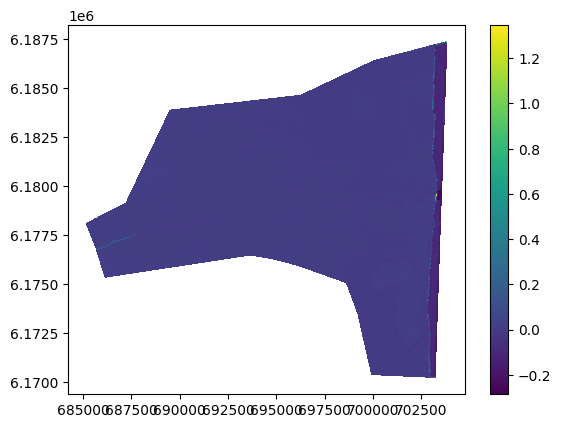

In [21]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],full_node_predictions[:,0],triangles=triangles)
plt.colorbar()

plt.show()

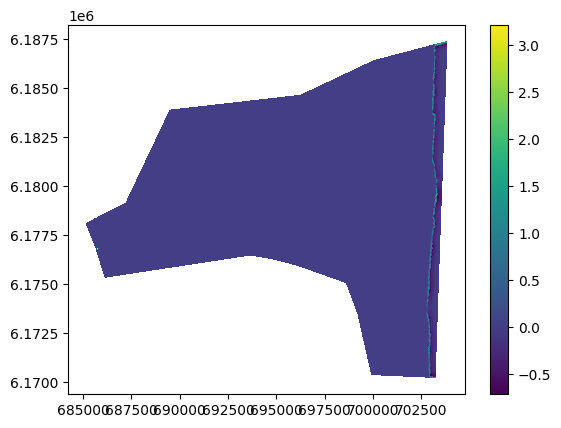

In [22]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],full_node_gd[:,0],triangles=triangles)
plt.colorbar()
plt.show()

In [23]:
full_node_gd[full_node_gd[:,0]<0,0]

tensor([-0.0219, -0.5000, -0.4912,  ..., -0.0647, -0.1183, -0.1230])